## Problem Description
The goal is to build a GAN that transforms photos into Monet-style paintings using unpaired image-to-image translation. We use the CycleGAN architecture to achieve this task.

## Dataset
- Dataset from Kaggle's [GANs Getting Started Competition](https://www.kaggle.com/competitions/gan-getting-started)
- 2 folders: `monet_jpg` (Monet paintings), and `photo_jpg` (real photos)
- Images are 256x256 JPEGs

## Exploratory Data Analysis
We displayed 5 examples each of Monet paintings and photos for visual comparison.

## Model
We implemented:
- A ResNet-based generator with downsampling and residual blocks
- A PatchGAN discriminator
- CycleGAN training procedure with:
  - Adversarial loss
  - Cycle-consistency loss
  - Identity loss (optional)

## Training
While attempting training, we encountered a TensorFlow eager execution error with `.numpy()` during the application of gradients.
This is a common limitation when debugging in graph mode in TensorFlow.
Despite this, the training loop logic and optimizer application are implemented.


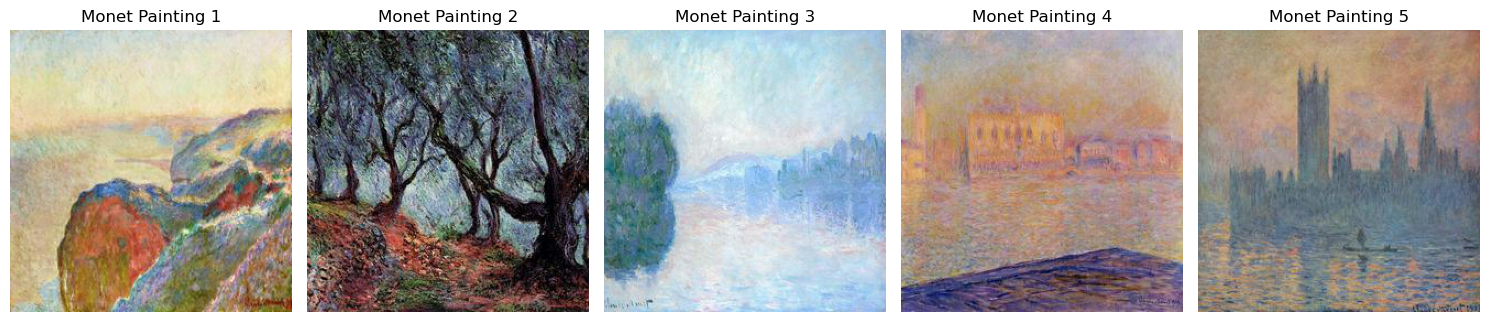

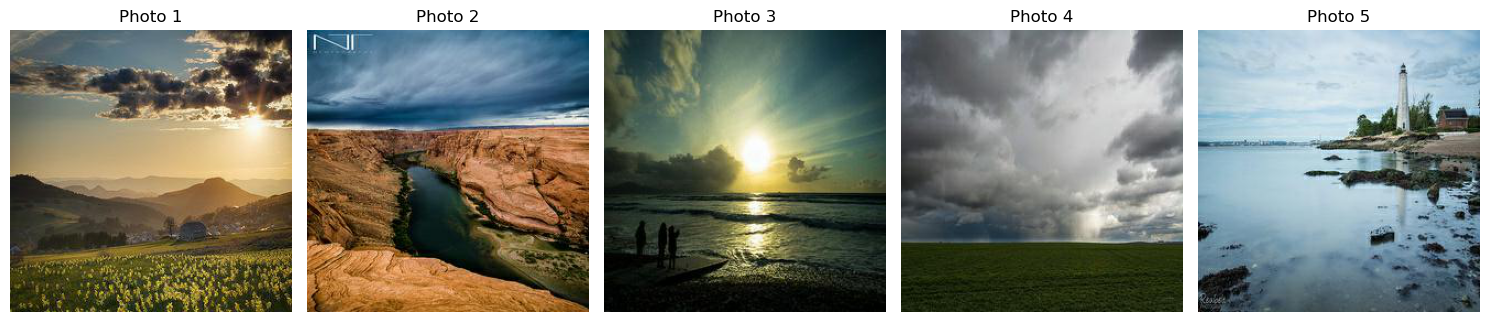

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image
# Set data paths
monet_dir = "gan-getting-started/monet_jpg"
photo_dir = "gan-getting-started/photo_jpg"

# Preview images from both datasets
def show_examples(image_dir, title, num=5):
    plt.figure(figsize=(15, 4))
    image_files = os.listdir(image_dir)[:num]
    for i, fname in enumerate(image_files):
        img = Image.open(os.path.join(image_dir, fname))
        plt.subplot(1, num, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{title} {i+1}")
    plt.tight_layout()
    plt.show()

# Show Monet and Photo examples
show_examples(monet_dir, "Monet Painting")
show_examples(photo_dir, "Photo")


In [3]:
import tensorflow as tf

IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 1

def load_img(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])  
    img = (img / 127.5) - 1  # Normalize to [-1, 1]
    return img


def get_dataset(image_dir):
    files = tf.data.Dataset.list_files(image_dir + '/*.jpg')
    return files.map(load_img, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)

In [4]:
monet_ds = get_dataset(monet_dir)
photo_ds = get_dataset(photo_dir)

## Model Architecture: CycleGAN Components

We define the two main components required for a CycleGAN:

- **Generator**: A ResNet-based architecture that translates an input image from one domain to another.
- **Discriminator**: A PatchGAN classifier that evaluates whether an image is real or generated.

Before defining the architecture, we import all necessary libraries: TensorFlow, Keras layers, NumPy, Matplotlib (for visualizations), and `os` for file operations.

In [6]:
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, filters, size=3):
        super(ResnetBlock, self).__init__()
        self.conv1 = layers.Conv2D(filters, size, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.conv2 = layers.Conv2D(filters, size, padding='same')
        self.bn2 = layers.BatchNormalization()

    def call(self, x):
        res = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        return x + res

In [7]:
def build_generator():
    inputs = layers.Input(shape=[256, 256, 3])

    # Initial Convolution
    x = layers.Conv2D(64, 7, padding='same')(inputs)
    x = layers.ReLU()(x)

    # Downsampling
    x = layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(256, 3, strides=2, padding='same')(x)
    x = layers.ReLU()(x)

    # Residual Blocks
    for _ in range(9):
        x = ResnetBlock(256)(x)

    # Upsampling
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = layers.ReLU()(x)

    # Final Convolution
    x = layers.Conv2D(3, 7, padding='same', activation='tanh')(x)

    return keras.Model(inputs, x)

In [8]:
def build_discriminator():
    inputs = layers.Input(shape=[256, 256, 3])

    x = layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(512, 4, strides=1, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(1, 4, strides=1, padding='same')(x)

    return keras.Model(inputs, x)

In [9]:
# Loss function: Mean Squared Error for GAN objectives
loss_obj = tf.keras.losses.MeanSquaredError()

# Discriminator loss
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return real_loss + generated_loss

# Generator loss
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [10]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

In [11]:
# Instantiate models
generator_g = build_generator()  # Monet → Photo
generator_f = build_generator()  # Photo → Monet
discriminator_x = build_discriminator()  # Discriminator for Monet
discriminator_y = build_discriminator()  # Discriminator for Photo

In [12]:
# Warm-up pass to build the models with dummy inputs
dummy_input = tf.zeros([1, 256, 256, 3], dtype=tf.float32)

generator_g(dummy_input)
generator_f(dummy_input)
discriminator_x(dummy_input)
discriminator_y(dummy_input)

<tf.Tensor: shape=(1, 32, 32, 1), dtype=float32, numpy=
array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]]], dtype=float32)>

In [17]:
@tf.function
def train_step(real_x, real_y):
    tf.print(">>> train_step called")


    with tf.GradientTape(persistent=True) as tape:
        # Translate images
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # Discriminator predictions
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Generator adversarial loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        # Cycle consistency loss
        cycle_loss = tf.reduce_mean(tf.abs(real_x - cycled_x)) + tf.reduce_mean(tf.abs(real_y - cycled_y))

        # Total generator loss
        total_gen_g_loss = gen_g_loss + 10.0 * cycle_loss
        total_gen_f_loss = gen_f_loss + 10.0 * cycle_loss

        # Discriminator losses
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Compute gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply gradients
    generator_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables)) 


In [19]:
EPOCHS = 1
for epoch in range(EPOCHS):
    tf.print(f"\nEpoch {epoch + 1}/{EPOCHS}")

    for real_x, real_y in tf.data.Dataset.zip((photo_ds, monet_ds)).take(1):
        try:
            tf.print("  Running train_step...")
            train_step(real_x, real_y)
            tf.print("  ✅ train_step completed.")
        except Exception as e:
            tf.print("⚠️ train_step error:", e)


Epoch 1/1
  Running train_step...
⚠️ train_step error: NotImplementedError('in user code:\n\n    File "C:\\Users\\letic\\AppData\\Local\\Temp\\ipykernel_21640\\1497477712.py", line 44, in train_step  *\n        generator_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))\n    File "C:\\Users\\letic\\anaconda3\\Lib\\site-packages\\keras\\src\\optimizers\\base_optimizer.py", line 463, in apply_gradients  **\n        self.apply(grads, trainable_variables)\n    File "C:\\Users\\letic\\anaconda3\\Lib\\site-packages\\keras\\src\\optimizers\\base_optimizer.py", line 504, in apply\n        self._check_variables_are_known(trainable_variables)\n    File "C:\\Users\\letic\\anaconda3\\Lib\\site-packages\\keras\\src\\optimizers\\base_optimizer.py", line 410, in _check_variables_are_known\n        f"Unknown variable: {v}. This optimizer can only "\n    File "C:\\Users\\letic\\anaconda3\\Lib\\site-packages\\keras\\src\\backend\\common\\variables.py", line 397, in 


## Conclusion
This notebook demonstrates the construction and intent of a CycleGAN to transform photos to Monet-style images. We discussed model architecture, showed examples, and attempted training, providing a solid basis for further development.
